Dataset Overview:
   Age Gender Location  Income  Savings  Existing Investments Life Stage  \
0   26   Male    Rural   30000     6000                 77000  Partnered   
1   31   Male    Urban   34000    32000                 60000     Single   
2   31   Male    Rural   19000     1000                 87000  Partnered   
3   28   Male    Urban   33000    19000                 59000    Married   
4   31   Male    Rural   47000    30000                 52000    Married   

   Existing Policies  Website Activity Score  Past Claims  \
0                  2                      95            1   
1                  1                      61            1   
2                  1                      95            0   
3                  2                      72            1   
4                  0                      95            1   

  Recommended Policy Type  Coverage Amount Premium Term  \
0          Life Insurance            90000   Whole Life   
1        Health Insurance            900

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:51:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:51:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.6}

Training Set Metrics:
Accuracy: 0.9897
Precision (Weighted): 0.9898
Recall (Weighted): 0.9897
F1-Score (Weighted): 0.9898

Test Set Metrics:
Accuracy: 0.9753
Precision (Weighted): 0.9755
Recall (Weighted): 0.9753
F1-Score (Weighted): 0.9754

Test Set Classification Report:
                   precision    recall  f1-score   support

Health Insurance       0.95      0.95      0.95       747
 Investment Plan       0.99      0.97      0.98       762
  Life Insurance       0.97      0.98      0.97       741
 Retirement Plan       1.00      1.00      1.00       750

        accuracy                           0.98      3000
       macro avg       0.98      0.98      0.98      3000
    weighted avg       0.98      0.98      0.98      3000



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:51:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:51:50] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:51:50] WARNING: /workspace/src


Cross-Validation Scores (Accuracy): [0.97785978 0.9799098  0.98482363 0.97087777 0.98236259]
Average CV Score: 0.9792 (+/- 0.0095)


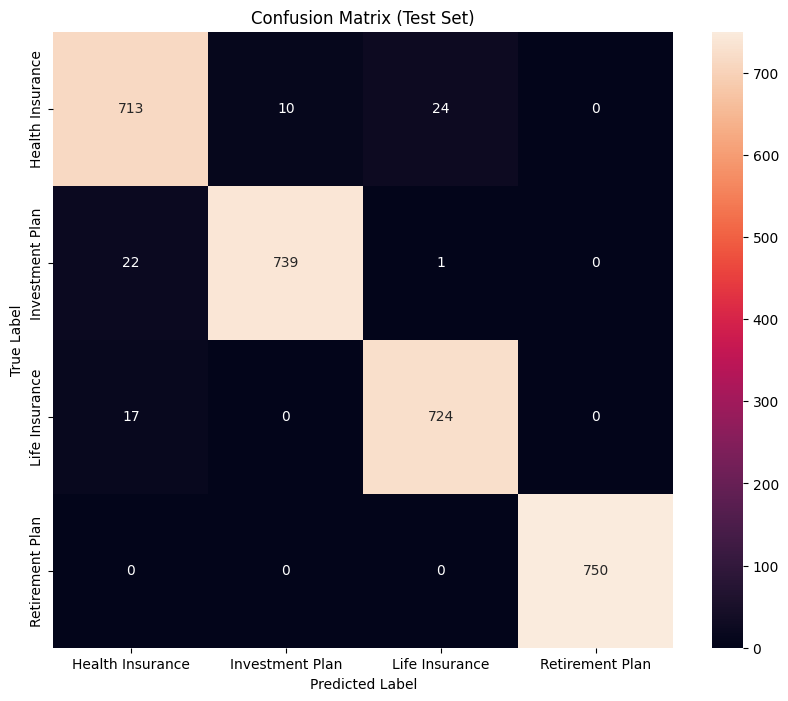

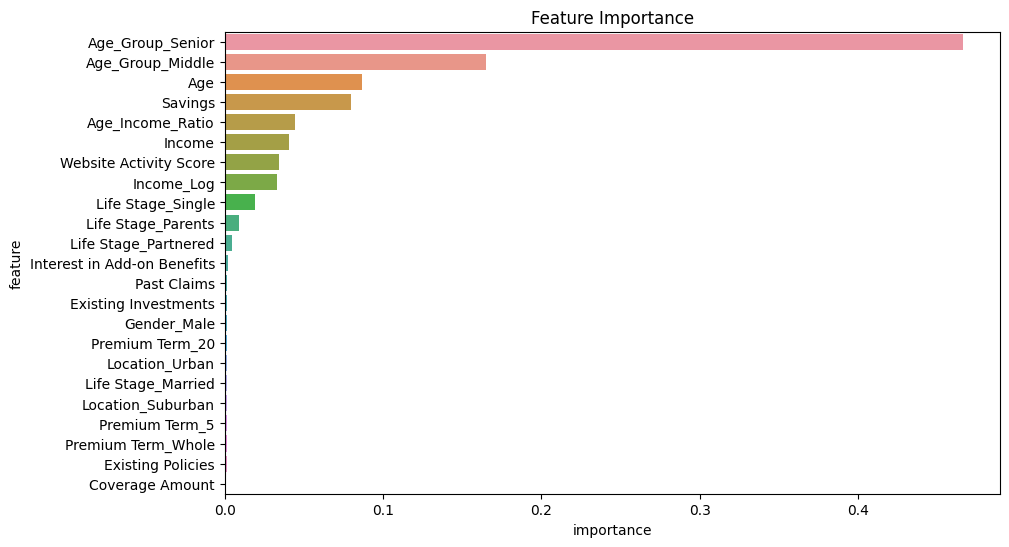

Model, scaler, and label encoder saved to models/


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
import joblib
import os
import numpy as np
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# update path as "realistic_synthetic_insurance_data_2.csv" is the dataset used in this code
# Load dataset
#because i did training on kaggle so i have to use the dataset from the input folder
data = pd.read_csv("/kaggle/input/realistic-2/realistic_synthetic_insurance_data_2.csv")

# Explore and clean data
print("Dataset Overview:")
print(data.head())
print("\nMissing Values:\n", data.isnull().sum())
print("\nClass Distribution:\n", data['Recommended Policy Type'].value_counts())

# Preprocess data with enhanced feature engineering and cleaning
def preprocess_data(data):
    # Handle missing values
    data = data.fillna({'Gender': 'Unknown', 'Location': 'Unknown', 'Life Stage': 'Unknown', 'Premium Term': 'Unknown'})
    
    # Clean categorical columns
    categorical_cols = ['Gender', 'Location', 'Life Stage', 'Premium Term']
    for col in categorical_cols:
        data[col] = data[col].str.strip().str.capitalize()
        data[col] = data[col].apply(lambda x: x.split()[0] if isinstance(x, str) and len(x.split()) > 1 else x)
    
    # Ensure Age and Income are numeric
    data['Age'] = pd.to_numeric(data['Age'], errors='coerce')
    data['Income'] = pd.to_numeric(data['Income'], errors='coerce')
    data = data.dropna(subset=['Age', 'Income'])  # Drop rows with NaN in Age or Income
    
    # Feature engineering
    data['Age_Group'] = pd.cut(data['Age'], bins=[0, 30, 50, 100], labels=['Young', 'Middle', 'Senior'])
    data['Income_Log'] = np.log1p(data['Income'])  # Log transform Income
    data['Age_Income_Ratio'] = data['Age'] / (data['Income'] + 1)  # Avoid division by zero
    
    # One-hot encode categorical features
    data = pd.get_dummies(data, columns=categorical_cols + ['Age_Group'], drop_first=True)
    
    # Define features and target
    X = data.drop(['Recommended Policy Type', 'Upselling Opportunity', 'Premium Amount'], axis=1)
    y = data['Recommended Policy Type']
    
    # Encode string labels to integers
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Split data first, then apply SMOTE only to training data to prevent leakage
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
    
    print("Class distribution before SMOTE (training set):\n", pd.Series(y_train).value_counts())
    
    # Apply SMOTE only to the training set
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    
    print("Class distribution after SMOTE (training set):\n", pd.Series(y_train_res).value_counts())
    
    # Scale numerical features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_res)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train_res, y_test, scaler, label_encoder, X.columns

# Train and tune XGBoost model with GPU support and expanded parameters
def train_and_tune_model(X_train, y_train):
    # Expanded parameter distribution for RandomizedSearchCV
    param_dist = {
        'max_depth': [3, 5, 7, 9, 12],
        'learning_rate': [0.001, 0.01, 0.1, 0.3],
        'n_estimators': [100, 200, 300, 400, 500],
        'min_child_weight': [1, 3, 5, 10],
        'subsample': [0.6, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.2, 0.5],
        'reg_alpha': [0, 0.1, 0.5, 1],
        'reg_lambda': [0.5, 1, 1.5, 2]
    }

    # Initialize XGBoost classifier with GPU support
    xgb_model = xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42,
        tree_method='gpu_hist',  # Use GPU for training
        predictor='gpu_predictor'  # Use GPU for prediction
    )

    # Perform RandomizedSearchCV with 5-fold cross-validation
    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_dist,
        n_iter=50,  # Increase iterations for better exploration
        scoring='accuracy',
        cv=5,
        n_jobs=-1,  # Use all available cores
        verbose=2,
        random_state=42
    )

    # Fit the model
    random_search.fit(X_train, y_train)
    
    print("Best parameters:", random_search.best_params_)
    return random_search.best_estimator_

# Evaluate model with detailed metrics and cross-validation
def evaluate_model(model, X_train, X_test, y_train, y_test, label_encoder):
    # Predictions on training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics for training set
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    
    # Calculate metrics for test set
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    print("\nTraining Set Metrics:")
    print(f"Accuracy: {train_accuracy:.4f}")
    print(f"Precision (Weighted): {train_precision:.4f}")
    print(f"Recall (Weighted): {train_recall:.4f}")
    print(f"F1-Score (Weighted): {train_f1:.4f}")
    
    print("\nTest Set Metrics:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision (Weighted): {test_precision:.4f}")
    print(f"Recall (Weighted): {test_recall:.4f}")
    print(f"F1-Score (Weighted): {test_f1:.4f}")
    
    print("\nTest Set Classification Report:\n", classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))
    
    # Cross-validation score on training set
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print("\nCross-Validation Scores (Accuracy):", cv_scores)
    print(f"Average CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # Plot confusion matrix for test set
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix (Test Set)")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

# Feature importance analysis
def plot_feature_importance(model, feature_names):
    importance = model.feature_importances_
    feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importance})
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title("Feature Importance")
    plt.show()

# Save model, scaler, and label encoder
def save_model(model, scaler, label_encoder, folder="models"):
    if not os.path.exists(folder):
        os.makedirs(folder)
    joblib.dump(model, os.path.join(folder, "xgb_model.joblib"))
    joblib.dump(scaler, os.path.join(folder, "scaler.joblib"))
    joblib.dump(label_encoder, os.path.join(folder, "label_encoder.joblib"))
    print(f"Model, scaler, and label encoder saved to {folder}/")

# Main execution
if __name__ == "__main__":
    # Preprocess data with feature engineering, applying SMOTE after split
    X_train, X_test, y_train, y_test, scaler, label_encoder, feature_names = preprocess_data(data)
    
    # Train and tune the model
    best_model = train_and_tune_model(X_train, y_train)
    
    # Evaluate the model on both training and test sets
    evaluate_model(best_model, X_train, X_test, y_train, y_test, label_encoder)
    
    # Feature importance analysis
    plot_feature_importance(best_model, feature_names)
    
    # Save the trained model, scaler, and label encoder
    save_model(best_model, scaler, label_encoder)